# Imports and Paths

In [1]:
import os

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

import matplotlib.gridspec as gridspec
import datetime as dt
mpl.rcParams['figure.facecolor'] = 'white'
import time

from palettable.cartocolors.qualitative import Prism_8
prism = Prism_8.mpl_colors
import xarray as xr
blue = prism[1]
green = prism[3]
purple = prism[0]
red = prism[7]
orange = prism[6]
yellow = prism[5]
gray = '#303039'

from palettable.cmocean.sequential import Tempo_20
tempo = mcolors.ListedColormap(Tempo_20.mpl_colors)
from palettable.cmocean.diverging import Balance_20
bal = Balance_20.mpl_colormap
from palettable.cmocean.diverging import Curl_20

curltop =  mcolors.ListedColormap(Curl_20.mpl_colors[10:])
curlbot =  mcolors.ListedColormap(Curl_20.mpl_colors[:10])
import sys
from palettable.cmocean.sequential import Deep_20
deep = mcolors.ListedColormap(Deep_20.mpl_colors)

from palettable.cmocean.diverging import Balance_20
bal = Balance_20.mpl_colormap

from palettable.cartocolors.diverging import Geyser_7
curl = Geyser_7.mpl_colormap

bal.set_bad('white')

from shared_functions import get_var
from run_params import *

In [2]:
style = '/home/gleung/scripts/styles/bee-paperlight.mplstyle'
plt.style.use(style)

import matplotlib.font_manager as font_manager
from matplotlib import rcParams

# Add every font at the specified location
font_dir = ['/home/gleung/scripts/futura']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)

# Set font family globally
rcParams['font.family'] = 'Futura'
rcParams["figure.facecolor"] = 'white'
rcParams['figure.dpi'] = 300  

In [3]:
dataPath = f"/camp2e/gleung/aerograd"

run = 'grad'
ccn = 'CCCMP'

anaPath = f"/camp2e/gleung/aerograd-analysis/"
figPath = f"/camp2e/gleung/aerograd-figures/"

if not os.path.isdir(figPath):
    os.mkdir(figPath)

# Read In Data

In [64]:
paths = [p for p in sorted(os.listdir(f"{dataPath}/{run}")) if p.startswith('a-L') and p.endswith('.h5')]

In [66]:
print(paths[::12])

['a-L-2019-09-16-000000-g1.h5', 'a-L-2019-09-16-010000-g1.h5', 'a-L-2019-09-16-020000-g1.h5', 'a-L-2019-09-16-030000-g1.h5', 'a-L-2019-09-16-040000-g1.h5', 'a-L-2019-09-16-050000-g1.h5', 'a-L-2019-09-16-060000-g1.h5', 'a-L-2019-09-16-070000-g1.h5', 'a-L-2019-09-16-080000-g1.h5', 'a-L-2019-09-16-090000-g1.h5', 'a-L-2019-09-16-100000-g1.h5', 'a-L-2019-09-16-110000-g1.h5', 'a-L-2019-09-16-120000-g1.h5']


a-L-2019-09-16-110000-g1.h5
1.522714111328125
1.522714111328125


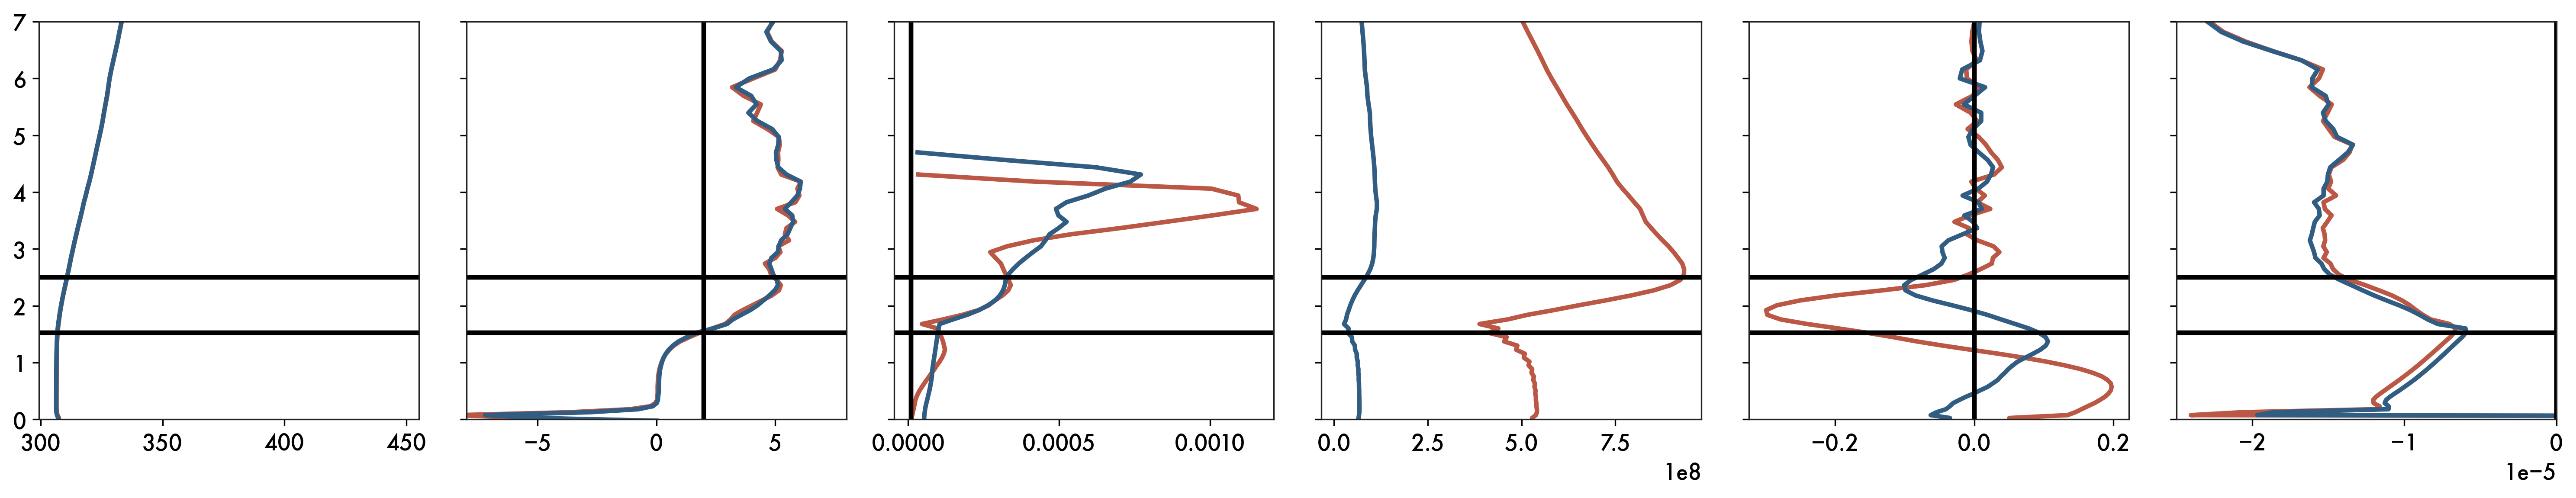

a-L-2019-09-16-120000-g1.h5
1.600123046875
1.600123046875


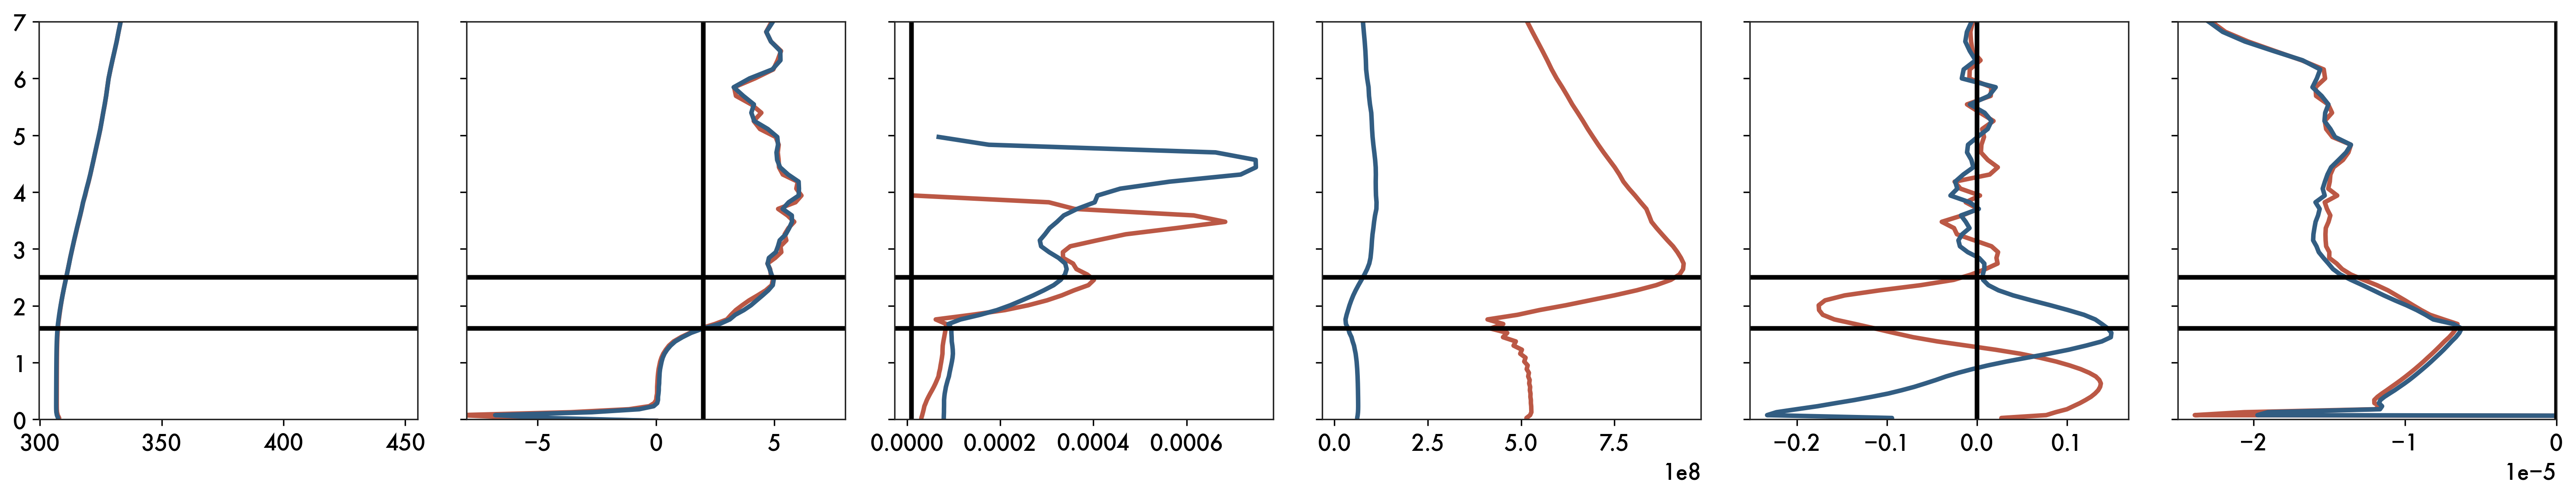

In [164]:
for p in paths[::12][-2:]:
    print(p)
    ds = xr.open_dataset(f"{dataPath}/{run}/{p}")
    ds = ds.rename_dims({'phony_dim_2':'z', 'phony_dim_1':'x', 'phony_dim_0':'y'})
    ds = ds.assign(alt = (alt/1000)[ds.z])
    ds = ds.assign(TCON = ds.RTP - ds.RV)
    ds = ds.swap_dims({'z':'alt'})
    ds = ds[['THETA','TCON','CCCNP','VC','FTHRD']]
    
    x = np.concatenate([(-ds.sel(y=(ds.y<500)).VC.data),ds.sel(y=(ds.y>=500)).VC.data],axis=1)
    ds = ds.assign(absVC = (('alt','y','x'),x))
    
    high = ds.sel(y=slice(400,600))
    cld_high = high.where(high.TCON>=1E-5).mean(dim=('x','y'))
    clr_high = high.where(high.TCON<1E-5).mean(dim=('x','y'))
    
    low = ds.sel(y=((ds.y<=100) | (ds.y>=900)))
    cld_low = low.where(low.TCON>=1E-5).mean(dim=('x','y'))
    clr_low = low.where(low.TCON<1E-5).mean(dim=('x','y'))
    
    fig, axes = plt.subplots(1,6,figsize=(20,4),sharey=True)

    for cld,clr in zip([cld_high,cld_low],
                       [clr_high,clr_low]):
        
        axes[0].plot(clr.THETA,alt/1000)

        axes[1].plot(clr.THETA.differentiate('alt'),alt/1000)
        axes[1].axvline(2)

        axes[2].plot(cld.TCON,alt/1000)
        axes[2].axvline(1E-5)

        axes[3].plot(clr.CCCNP,alt/1000)

        axes[4].plot(clr.absVC,alt/1000)
        axes[4].axvline(0)
        
        axes[5].plot(clr.FTHRD,alt/1000)
        axes[5].axvline(0)
        
        out = (clr.THETA.differentiate('alt')<=2).to_dataframe().THETA

        mlh = out.index[out!=out.shift(-1)][0]

        print(mlh)

        for ax in axes:
            ax.axhline(2.5)
            ax.axhline(mlh)
            
        ax.set_ylim(0,7)
        axes[1].set_xlim(-8,8)
        axes[-1].set_xlim(-2.5E-5,0)

    plt.show()
    plt.close('all')

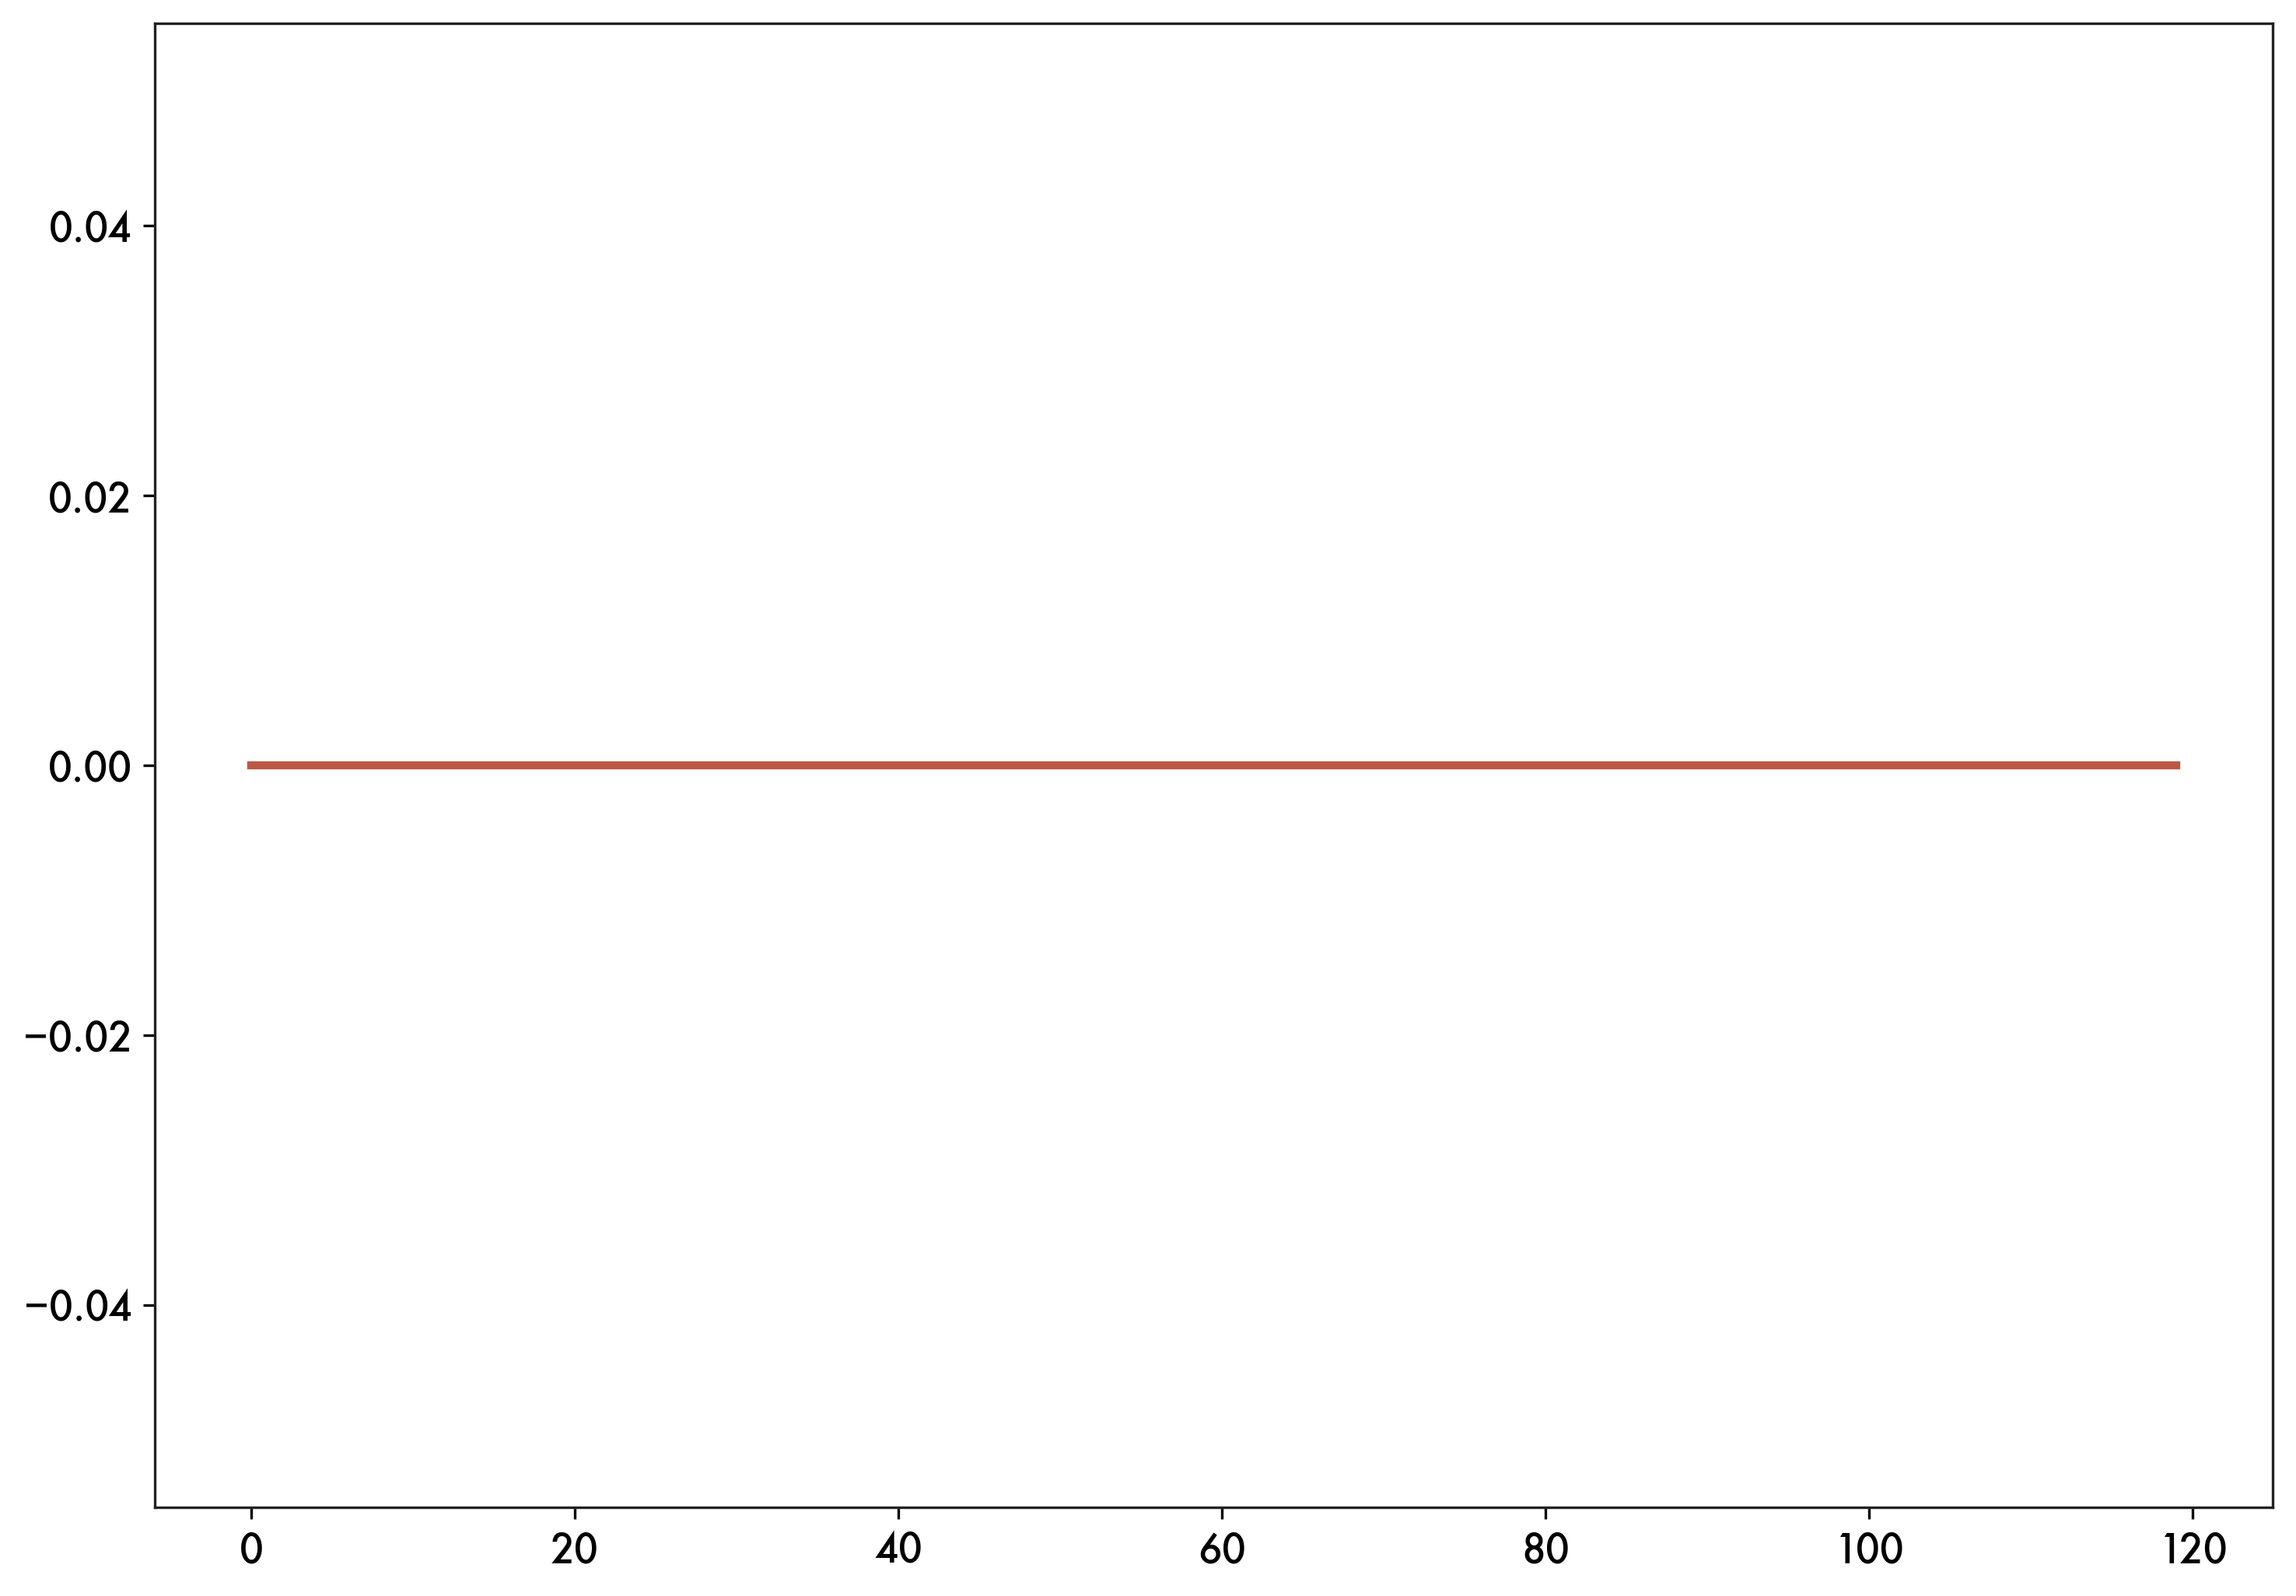

In [154]:
plt.plot(clr_low.absVC)

In [145]:

print(x)

[[[-0. -0. -0. ... -0. -0. -0.]
  [-0. -0. -0. ... -0. -0. -0.]
  [-0. -0. -0. ... -0. -0. -0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[-0. -0. -0. ... -0. -0. -0.]
  [-0. -0. -0. ... -0. -0. -0.]
  [-0. -0. -0. ... -0. -0. -0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[-0. -0. -0. ... -0. -0. -0.]
  [-0. -0. -0. ... -0. -0. -0.]
  [-0. -0. -0. ... -0. -0. -0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 ...

 [[-0. -0. -0. ... -0. -0. -0.]
  [-0. -0. -0. ... -0. -0. -0.]
  [-0. -0. -0. ... -0. -0. -0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]]

 [[-0. -0. -0. ... -0. -0. -0.]
  [-0. -0. -0. ... -0. -0. -0.]
  [-0. -0. -0. ... -0. -0. -0.]
  ...
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  0.]
  [ 0.  0.  0. ...  0.  0.  

In [148]:

print(ds)

<xarray.Dataset>
Dimensions:  (alt: 120, y: 1000, x: 1000)
Coordinates:
    z        (alt) int64 0 1 2 3 4 5 6 7 8 ... 112 113 114 115 116 117 118 119
  * alt      (alt) float64 -0.02467 0.02489 0.07534 0.1267 ... 18.71 19.01 19.31
Dimensions without coordinates: y, x
Data variables:
    THETA    (alt, y, x) float32 ...
    TCON     (alt, y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    CCCNP    (alt, y, x) float32 ...
    VC       (alt, y, x) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    absVC    (alt, y, x) float32 -0.0 -0.0 -0.0 -0.0 -0.0 ... 0.0 0.0 0.0 0.0


In [126]:
print(ds.absVC)

<xarray.DataArray 'absVC' (alt: 120, y: 1000, x: 1000)>
[120000000 values with dtype=float32]
Coordinates:
    z        (alt) int64 0 1 2 3 4 5 6 7 8 ... 112 113 114 115 116 117 118 119
  * alt      (alt) float64 -0.02467 0.02489 0.07534 0.1267 ... 18.71 19.01 19.31
Dimensions without coordinates: y, x
